## init

In [63]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


|======== Timed report ========
| reduce sparse                    :     451.45ms  (225.724ms per; #2)
| vineyard.get_state_at_point      :     137.93ms  ( 0.005ms per; #30514)
| reduce_vine: ordering            :   34450.07ms  ( 1.129ms per; #30514)
| reduce_vine: transpositions_lean :  297819.24ms  ( 9.760ms per; #30514)
| reduce_vine: sparse matrix copies:  492448.49ms  (16.138ms per; #30514)
| perform_one_swap case 3          :  213929.61ms  ( 0.007ms per; #32352247)
| reduce_vine: perform_one_swap    : 5784343.97ms  ( 0.044ms per; #131065389)
| low_inv                          : 4689588.72ms  ( 0.143ms per; #32738872)
| perform_one_swap case 1          : 4919044.85ms  ( 0.150ms per; #32738872)
| perform_one_swap case 4          :  221091.97ms  ( 0.007ms per; #33183767)
| perform_one_swap case 2          :  242904.82ms  ( 0.007ms per; #32790503)
| reduce_vine: loop                : 6231009.63ms  (204.202ms per; #30514)
|==============================


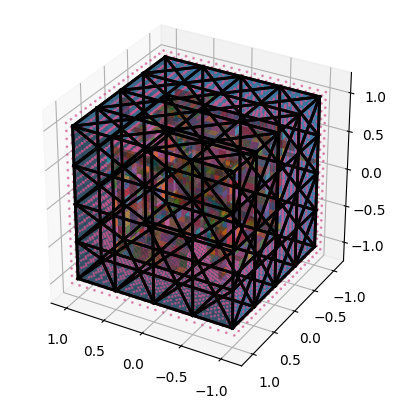

In [89]:
example = ex.cube_3

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, a: np.ndarray, b: np.ndarray):
    super().on_faustian(s1, s2, a, b)
    if s1.dim() == 0:
      cob1 = set(our_complex.get_coboundary(s1))
      cob2 = set(our_complex.get_coboundary(s2))
      if cob1 & cob2:
        return
      c1 = gridd.cell_of(a)
      c2 = gridd.cell_of(b)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    v.reduce(center_point)
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    v.reduce_vine(old_state, new_point)

gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)